## DS 340W Final Code: Opinion Summarization on AmaSum

Group 11  
Rohan Dalal and Pratham Patel

Topic: Reproducing and improving PoCa on the AmaSum review summarization dataset

Agenda:

1. Setup and configuration  
2. Data and repo
3. Building gold summaries and input review texts  
4. Reproduction of the parent paper  
5. Enhancement 1: Sentence level evidence attribution
6. Enhancement 2: Pros and cons balance analysis  
7. Enhancement 3: Coverage aware PoCa summaries
8. Extra analysis: Aspect keyword buckets and recall  
9. Final combined metrics table for all systems  

## Setup and Configuration

In [ ]:
# Installs
!pip install -q sentence-transformers transformers evaluate accelerate

# Imports
import os, json, csv, random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

import nltk
from nltk.tokenize import sent_tokenize

from sentence_transformers import SentenceTransformer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForSeq2SeqLM,
)

from evaluate import load
import matplotlib.pyplot as plt

# NLTK stuff
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)

True

**Dataset setup**  
We store the original AmaSum zip file in our Google Drive at in a folder called "AmaSum" and set path to that exact location.  

If someone runs this notebook on their own account they can either keep the same folder name or update path to wherever they upload the AmaSum zip.

We also set the split to test for the reproduction and all enhancements, since the parent paper reports results on the AmaSum test split.

The dataset can be downloaded from https://github.com/abrazinskas/SelSum/tree/master/data - The version that contains a maximum of 100 reviews per product for experiments (JSONL)

In [ ]:
import os, sys, json, csv, re, pathlib, random, numpy as np, torch
from google.colab import drive

drive.mount('/content/drive')

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = False

ROOT = pathlib.Path("/content")
DATA_ZIP_PATH = "/content/drive/MyDrive/AmaSum/raw_min_10_max_100_revs.zip"

SPLIT = "test"  # "train", "test", or "valid"
K_RETRIEVE = 5
NLI_THRESH = 0.6
MIN_SENT_LEN = 30
USE_FROZEN_CONFIG = False

Mounted at /content/drive


In [ ]:
print({
    "python": sys.version.split()[0],
    "torch": torch.__version__,
})

{'python': '3.12.12', 'torch': '2.8.0+cu126'}


## Data and Repo

Here we:
- Unzip the AmaSum dataset
- Clone the parent code repository from github  
- Change our working directory to the repo so we can reuse their scripts and file structure

We only unzip the data if the folder is empty.

In [ ]:
import os

if not os.path.exists("/content/data/AmaSum") or not os.listdir("/content/data/AmaSum"):
    !mkdir -p /content/data/AmaSum
    !unzip -q {DATA_ZIP_PATH} -d /content/data/AmaSum

!git clone https://github.com/yuanyuanlei-nlp/polarity_calibration_naacl_2024.git
%cd /content/polarity_calibration_naacl_2024

Cloning into 'polarity_calibration_naacl_2024'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 401 (delta 15), reused 0 (delta 0), pack-reused 372 (from 1)
Receiving objects: 100% (401/401), 890.21 KiB | 16.49 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/polarity_calibration_naacl_2024


## Build Gold and Input Texts

The AmaSum JSON files contain:
- A set of customer reviews for each product  
- A website level summary with a verdict, pros, and cons

Here we create two folders inside the PoCa repo:
-  one gold summary text file per product  
- one text file with all review sentences for that product

In the project what "gold" really means is the website summary from AmaSum.  
For each product we build the gold string as: verdict + all pros + all cons

We also clean up the review text and keep only reasonably long sentences as input.

In [ ]:
repo = pathlib.Path("/content/polarity_calibration_naacl_2024")
amasum = pathlib.Path("/content/data/AmaSum/min_10_max_100_revs_filt_complete")
preds_root = repo / "generated_summary_AmaSum"

# authors give test ids for their predictions
test_ids_file = preds_root / "test_file_names.txt"
all_test_ids = [x.strip() for x in open(test_ids_file, encoding="utf-8") if x.strip()]

gold_dir = repo / "work_amasum" / f"gold_{SPLIT}"
inp_dir  = repo / "work_amasum" / f"input_texts_{SPLIT}"
os.makedirs(gold_dir, exist_ok=True)
os.makedirs(inp_dir,  exist_ok=True)

split_dir = amasum / SPLIT
files = {p.stem: p for p in split_dir.glob("*.json")}

def get_reviews_list(D):
    if isinstance(D.get("reviews"), list): return D["reviews"]
    if isinstance(D.get("customer_reviews"), list): return D["customer_reviews"]
    return []

def clean_txt(s: str) -> str:
    s = s.replace("\u2013", "-").replace("\u2014", "-")
    s = re.sub(r"\s+", " ", s).strip()
    return s

ids = []
missing = []
for p in split_dir.glob("*.json"):
    _id = p.stem
    ids.append(_id)
    data = json.loads(p.read_text(encoding="utf-8"))

    ws = data["website_summaries"][0]
    verdict = clean_txt(ws.get("verdict") or "")
    pros = ". ".join([clean_txt(x) for x in ws.get("pros", []) if clean_txt(x)])
    cons = ". ".join([clean_txt(x) for x in ws.get("cons", []) if clean_txt(x)])
    if pros and not pros.endswith("."): pros += "."
    if cons and not cons.endswith("."): cons += "."
    gold = " ".join([x for x in [verdict, pros, cons] if x]).strip()
    (gold_dir / f"{_id}.txt").write_text(gold, encoding="utf-8")

    reviews = get_reviews_list(data)
    texts = []
    for r in reviews:
        t = clean_txt((r.get("text") or ""))
        if not t: continue
        ttl = clean_txt((r.get("title") or ""))
        body = f"{ttl}. {t}" if ttl else t
        if len(body) >= 40:
            texts.append(body)
    joined = "\n".join(texts)
    (inp_dir / f"{_id}.txt").write_text(joined, encoding="utf-8")

print("total ids in split:", len(ids))

total ids in split: 3166


## Reproduction

### Rouge

Here we reproduce the main ROUGE results for the two original systems:
- base: flan-T5 summarizer  
- poca: polarity calibrated summarizer

We:
1. Read the model predictions from the files released by the authors which we found on their github
2. Align them with the ordered list of test ids  
3. Load our gold summaries we computed above
4. Compute ROUGE-1, ROUGE-2, ROUGE-L, and ROUGE-Lsum

This gives us a small table so we can check that our scores follow the same pattern as the parent paper

In [ ]:
import pandas as pd
from evaluate import load

art = repo / "artifacts"
art.mkdir(exist_ok=True)

if SPLIT == "test":
    # base system and PoCa system from the parent paper
    systems = {
        "base": preds_root / "base_summarizer_flan_t5_large.txt",
        "poca": preds_root / "calibrated_summarizer_PoCa.txt",
    }

    rouge = load("rouge")
    rows = []

    # test ids given by the authors
    test_ids_ordered = all_test_ids

    for name, pred_file in systems.items():
        # model summaries
        hyps_all = [
            ln.strip()
            for ln in open(pred_file, encoding="utf-8").read().splitlines()
        ]

        n = min(len(test_ids_ordered), len(hyps_all))

        # gold summaries
        refs = [
            (repo / "work_amasum" / f"gold_{SPLIT}" / f"{test_ids_ordered[i]}.txt"
            ).read_text(encoding="utf-8")
            for i in range(n)
        ]
        hyps = [hyps_all[i] for i in range(n)]

        scores = rouge.compute(
            predictions=hyps,
            references=refs,
            use_stemmer=True
        )

        row = {
            "system": name,
            "ROUGE1": round(scores["rouge1"] * 100, 2),
            "ROUGE2": round(scores["rouge2"] * 100, 2),
            "ROUGEL": round(scores["rougeL"] * 100, 2),
            "ROUGELsum": round(scores["rougeLsum"] * 100, 2),
        }
        rows.append(row)

    rouge_df = pd.DataFrame(rows)
    rouge_csv_path = art / f"rouge_summary_table_{SPLIT}.csv"
    rouge_df.to_csv(rouge_csv_path, index=False)

    print("ROUGE scores saved to:", rouge_csv_path)
    display(
        rouge_df.rename(
            columns={
                "system": "Summary system",
                "ROUGE1": "ROUGE-1 F1",
                "ROUGE2": "ROUGE-2 F1",
                "ROUGEL": "ROUGE-L F1",
                "ROUGELsum": "ROUGE-Lsum F1",
            }
        )
    )
else:
    print("ROUGE reproduction runs only for SPLIT == 'test'")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ROUGE scores saved to: /content/polarity_calibration_naacl_2024/artifacts/rouge_summary_table_test.csv


,Summary system,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,ROUGE-Lsum F1
0,base,29.21,5.67,17.18,17.20
1,poca,28.42,5.14,16.95,16.95


#### Visual

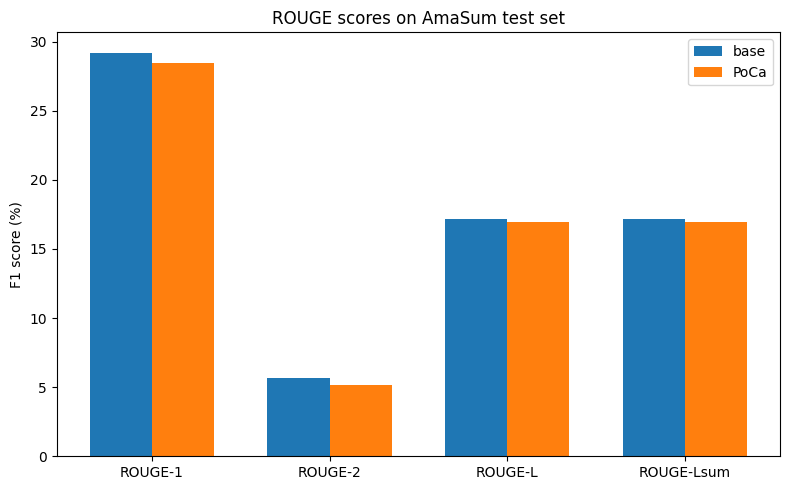

In [ ]:
metrics = ["ROUGE1", "ROUGE2", "ROUGEL", "ROUGELsum"]

x = np.arange(len(metrics))
width = 0.35

base_scores = rouge_df[rouge_df["system"] == "base"][metrics].values[0]
poca_scores = rouge_df[rouge_df["system"] == "poca"][metrics].values[0]

plt.figure(figsize=(8, 5))

plt.bar(x - width/2, base_scores, width, label="base")
plt.bar(x + width/2, poca_scores, width, label="PoCa")

plt.xticks(x, ["ROUGE-1", "ROUGE-2", "ROUGE-L", "ROUGE-Lsum"])
plt.ylabel("F1 score (%)")
plt.title("ROUGE scores on AmaSum test set")
plt.legend()
plt.tight_layout()
plt.show()

### Polarity

The main idea of the parent paper is to match the sentiment of the summary to the sentiment of the input reviews.

To measure this we:
- Use the RoBERTa sentiment model
- Estimate a positive sentiment probability for the input reviews of each product  
- Estimate the positive sentiment probability for the generated summary of that product  
- Look at the difference between summary sentiment and input sentiment across all products

We then report RMSE and MAE

Lower is better...smaller gaps mean the summary sentiment is better aligned with the reviews

In [ ]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

if SPLIT == "test":
    systems = {
        "base": preds_root / "base_summarizer_flan_t5_large.txt",
        "poca": preds_root / "calibrated_summarizer_PoCa.txt",
    }

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # sentiment model
    ckpt = "siebert/sentiment-roberta-large-english"
    tok = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    mdl = AutoModelForSequenceClassification.from_pretrained(ckpt).to(device).eval()

    def pos_prob(text):
        sents = [s for s in sent_tokenize(text) if s.strip()]
        if not sents:
            return 0.5
        probs = []
        with torch.no_grad():
            for s in sents:
                enc = tok(
                    s,
                    truncation=True,
                    return_tensors="pt"
                ).to(device)
                logits = mdl(**enc).logits
                p = torch.softmax(logits, dim=-1)[0, 1].item()
                probs.append(p)
        return float(np.mean(probs))

    def rmse(xs):
        return float(np.sqrt(np.mean(np.square(xs))))

    def mae(xs):
        return float(np.mean(np.abs(xs)))

    rows = []

    for name, pred_file in systems.items():
        hyps_all = [
            ln.strip()
            for ln in open(pred_file, encoding="utf-8").read().splitlines()
        ]
        n = min(len(all_test_ids), len(hyps_all))

        diffs = []
        for i in range(n):
            _id = all_test_ids[i]
            # input reviews for this product
            x = (inp_dir / f"{_id}.txt").read_text(encoding="utf-8")
            # system summary for this product
            y = hyps_all[i]

            pin = pos_prob(x)
            pout = pos_prob(y)
            diffs.append(pout - pin)

        row = {
            "system": name,
            "RMSE": round(rmse(diffs), 4),
            "MAE": round(mae(diffs), 4),
        }
        rows.append(row)

    polarity_df = pd.DataFrame(rows)
    polarity_csv_path = art / f"polarity_summary_table_{SPLIT}.csv"
    polarity_df.to_csv(polarity_csv_path, index=False)

    print("Polarity alignment scores saved to:", polarity_csv_path)
    display(
        polarity_df.rename(
            columns={
                "system": "Summary system",
                "RMSE": "Polarity RMSE",
                "MAE": "Polarity MAE",
            }
        )
    )
else:
    print("Polarity reproduction runs only for SPLIT == 'test'")

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Polarity alignment scores saved to: /content/polarity_calibration_naacl_2024/artifacts/polarity_summary_table_test.csv


,Summary system,Polarity RMSE,Polarity MAE
0,base,0.2181,0.1775
1,poca,0.1908,0.1557


#### Visual

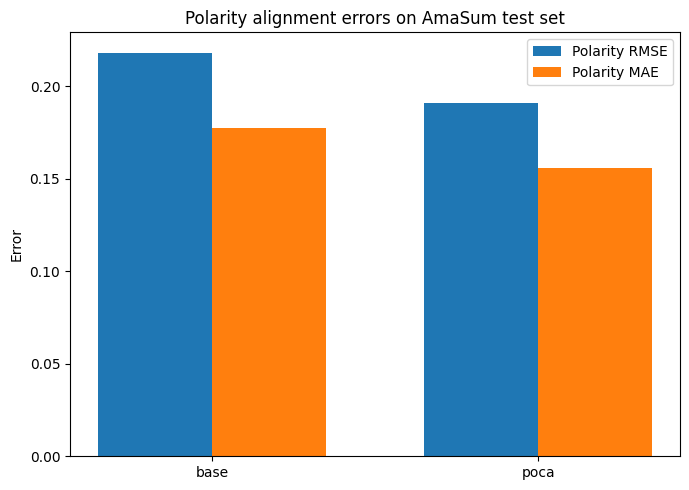

In [ ]:
x = np.arange(len(polarity_df["system"]))
width = 0.35

rmse_vals = polarity_df["RMSE"].values
mae_vals = polarity_df["MAE"].values

plt.figure(figsize=(7, 5))

plt.bar(x - width/2, rmse_vals, width, label="Polarity RMSE")
plt.bar(x + width/2, mae_vals, width, label="Polarity MAE")

plt.xticks(x, polarity_df["system"])
plt.ylabel("Error")
plt.title("Polarity alignment errors on AmaSum test set")
plt.legend()
plt.tight_layout()
plt.show()

Below, we just generate a small set of example summaries from the base flan-T5 model on the test split

We:
- Take the first N test products  
- Feed their review text to flan-T5 with a simple prompt  
- Save the generated summaries to a text file

This is just so we can read what the base model is doing on real products

In [ ]:
if SPLIT == "test":
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

    device = "cuda" if torch.cuda.is_available() else "cpu"
    tok2 = AutoTokenizer.from_pretrained("google/flan-t5-large")
    gen_model = AutoModelForSeq2SeqLM.from_pretrained(
        "google/flan-t5-large"
    ).to(device).eval()

    N_DEMO = 10
    demo_ids = all_test_ids[:N_DEMO]
    demo_out = repo / "work_amasum" / f"gen_demo_base_{SPLIT}.txt"

    with open(demo_out, "w", encoding="utf-8") as f:
        for _id in demo_ids:
            x = (inp_dir / f"{_id}.txt").read_text(encoding="utf-8")
            prompt = "Summarize the following customer reviews: " + x[:6000]
            enc = tok2(
                prompt,
                truncation=True,
                max_length=512,
                return_tensors="pt"
            ).to(device)
            with torch.no_grad():
                out = gen_model.generate(
                    **enc,
                    max_new_tokens=128,
                    num_beams=5,
                    no_repeat_ngram_size=3,
                )
            y = tok2.decode(out[0], skip_special_tokens=True).strip()
            f.write(y + "\n")

    print("example summaries written to...", demo_out)
else:
    print("Demo generation runs only for SPLIT == 'test'")

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

example summaries written to... /content/polarity_calibration_naacl_2024/work_amasum/gen_demo_base_test.txt


## Enhancement 1

Goal: Connect each summary sentence to the specific review sentences that support it.

Here we:
1. Split each product review document into individual sentences  
2. Encode all review sentences using a sentence embedding model  
3. For each summary sentence retrieve the top K similar review sentences  
4. Use an NLI model to check if each candidate review sentence actually entailsthe summary sentence  
5. Keep only review sentences whose entailment probability is above the threshold

This gives us a small list of review sentences that act as evidence for every summary sentence

In [ ]:
import nltk, json, csv, numpy as np, torch
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.tokenize import sent_tokenize

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

import pandas as pd
from IPython.display import display

In [ ]:
review_sents = {}

if SPLIT == "test":
    for _id in ids:
        doc = (inp_dir / f"{_id}.txt").read_text(encoding="utf-8")
        sents = [s.strip() for s in sent_tokenize(doc)]
        # remove duplicates, empty strings, and very short sentences
        sents = [s for s in dict.fromkeys(sents) if s and len(s) >= MIN_SENT_LEN]
        review_sents[_id] = sents

    print("Built review sentence lists for", len(review_sents), "products")
else:
    print("Enhancement 1 runs only for SPLIT = 'test'")

Built review sentence lists for 3166 products


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

embedder = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2",
    device=device
)

prod_embeddings = {}

def get_prod_emb(_id):
    if _id not in prod_embeddings:
        if len(review_sents.get(_id, [])) == 0:
            prod_embeddings[_id] = np.zeros((0, 384), dtype=np.float32)
        else:
            prod_embeddings[_id] = embedder.encode(
                review_sents[_id],
                convert_to_numpy=True,
                normalize_embeddings=True
            )
    return prod_embeddings[_id]

def topk_indices(mat, k):
    k = min(k, mat.shape[1])
    if k <= 0:
        return np.zeros((mat.shape[0], 0), dtype=int)
    return np.argpartition(-mat, kth=k-1, axis=1)[:, :k]

def retrieve_topk(_id, query_sents, k):
    ref = get_prod_emb(_id)
    if ref.shape[0] == 0:
        return [[] for _ in query_sents]
    Q = embedder.encode(
        query_sents,
        convert_to_numpy=True,
        normalize_embeddings=True
    )
    sims = np.matmul(Q, ref.T)
    idxs = topk_indices(sims, k)
    out = []
    for i in range(idxs.shape[0]):
        cand = [(int(j), float(sims[i, j])) for j in idxs[i]]
        cand.sort(key=lambda x: x[1], reverse=True)
        out.append(cand)
    return out

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
nli_ckpt = "cross-encoder/nli-deberta-v3-base"
nli_tok = AutoTokenizer.from_pretrained(nli_ckpt, use_fast=True)
nli_mdl = AutoModelForSequenceClassification.from_pretrained(nli_ckpt).to(device).eval()

ENTAIL_IDX = 2

def entail_prob(premise, hypothesis):
    enc = nli_tok(
        premise,
        hypothesis,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        logits = nli_mdl(**enc).logits
    return float(F.softmax(logits, dim=-1)[0, ENTAIL_IDX].item())

def dedup_keep_order(items):
    seen = set()
    out = []
    for x in items:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Below we apply the evidence pipeline to:
- The base summaries  
- The PoCa summaries

For each product we save:
- The summary sentences  
- A list of evidence sentences for each summary sentence, and also their entailment scores

In [ ]:
evidence_files = {}

if SPLIT == "test":
    systems = {
        "base": preds_root / "base_summarizer_flan_t5_large.txt",
        "poca": preds_root / "calibrated_summarizer_PoCa.txt",
    }

    for name, pred_file in systems.items():
        lines = [ln.strip() for ln in open(pred_file, encoding="utf-8").read().splitlines()]
        out_path = art / f"evidence_{name}_{SPLIT}.jsonl"

        with open(out_path, "w", encoding="utf-8") as w:
            for i, _id in enumerate(all_test_ids):
                # handle missing review sentences or missing summary line
                if _id not in review_sents or i >= len(lines):
                    w.write(json.dumps({"id": _id, "sentences": []}) + "\n")
                    continue

                summ = lines[i].strip()
                summ_sents = [s.strip() for s in sent_tokenize(summ) if s.strip()]
                # ignore very short summary sentences
                summ_sents = [s for s in summ_sents if len(s) >= 20]

                rev_s = review_sents[_id]

                if not summ_sents:
                    w.write(json.dumps({"id": _id, "sentences": []}) + "\n")
                    continue

                # retrieve top K review sentences per summary sentence
                cand = retrieve_topk(_id, summ_sents, k=K_RETRIEVE)
                bundle = []

                for idx_sent, s in enumerate(summ_sents):
                    evs = []
                    for j, _sim in cand[idx_sent]:
                        prem = rev_s[j]
                        p_ent = entail_prob(prem, s)
                        if p_ent >= NLI_THRESH:
                            evs.append({
                                "text": prem,
                                "entail_p": round(p_ent, 4)
                            })

                    # remove duplicate evidence sentences
                    texts = [e["text"] for e in evs]
                    keep_texts = dedup_keep_order(texts)
                    evs_final = []
                    for t in keep_texts:
                        for e in evs:
                            if e["text"] == t:
                                evs_final.append(e)
                                break

                    bundle.append({
                        "summary_sent": s,
                        "evidence": evs_final
                    })

                w.write(json.dumps({"id": _id, "sentences": bundle}) + "\n")

        evidence_files[name] = out_path
        print(f"Wrote evidence file... {name} to {out_path}")
else:
    print("Evidence files are only built for SPLIT = 'test'")

Wrote evidence file... base to /content/polarity_calibration_naacl_2024/artifacts/evidence_base_test.jsonl
Wrote evidence file... poca to /content/polarity_calibration_naacl_2024/artifacts/evidence_poca_test.jsonl


We compute simple sentence level attribution metrics for each system using the evidence files:

- Attribution at 1: fraction of summary sentences that have at least one supporting review sentence  
- Unsupported_rate: fraction of summary sentences with no evidence at all  
- Mean entailing supports: average number of evidence sentences per summary sentence  
- Total summary sentences: total number of sentences evaluated

These metrics tell us how well each system grounds its summary sentences in actual reviews according to our NLI model

In [ ]:
attr_rows = []

if SPLIT == "test":
    for name, fpath in evidence_files.items():
        total_sents = 0
        supported = 0
        support_counts = []

        with open(fpath, encoding="utf-8") as f:
            for line in f:
                rec = json.loads(line)
                for s in rec.get("sentences", []):
                    total_sents += 1
                    c = len(s.get("evidence", []))
                    support_counts.append(c)
                    if c >= 1:
                        supported += 1

        if total_sents == 0:
            attr1, unsup, mean_sup = 0.0, 0.0, 0.0
        else:
            attr1 = supported / total_sents
            unsup = 1.0 - attr1
            mean_sup = float(np.mean(support_counts))

        attr_rows.append({
            "system": name,
            "Attribution_at_1": round(attr1, 4),
            "Unsupported_rate": round(unsup, 4),
            "Mean_entailing_supports": round(mean_sup, 4),
            "Total_summary_sentences": total_sents
        })

    attr_path = art / f"attr_table_{SPLIT}.csv"
    with open(attr_path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=attr_rows[0].keys())
        w.writeheader()
        w.writerows(attr_rows)

    print("Attribution table saved to:", attr_path)

    attr_df = pd.DataFrame(attr_rows)
    display(attr_df)
else:
    print("Attribution table is only built for SPLIT == 'test'")

Attribution table saved to: /content/polarity_calibration_naacl_2024/artifacts/attr_table_test.csv


,system,Attribution_at_1,Unsupported_rate,Mean_entailing_supports,Total_summary_sentences
0,base,0.9720,0.0280,4.0366,930
1,poca,0.9584,0.0416,3.8775,865


In [ ]:
if SPLIT == "test":
    sample_system = "poca"   # or "base""
    sample_id = all_test_ids[0]

    fpath = evidence_files[sample_system]
    sample_record = None
    with open(fpath, encoding="utf-8") as f:
        for line in f:
            rec = json.loads(line)
            if rec.get("id") == sample_id:
                sample_record = rec
                break

    if sample_record is not None:
        print("Sample system:", sample_system)
        print("Sample id:", sample_id)
        print()

        for s in sample_record.get("sentences", [])[:3]:
            print("Summary sentence:")
            print(" ", s["summary_sent"])
            print("Evidence:")
            for ev in s["evidence"][:3]:
                print("  -", ev["text"])
            print()
    else:
        print("No record found for", sample_id)

Sample system: poca
Sample id: B01LXJA5JD

Summary sentence:
  The Roku Express is a good choice if you're looking for a streaming device that's easy to set up and use, but it's not the best choice for those who need a lot of storage space.
Evidence:
  - We have used RoKu at home for several years, and love the simplicity and integration of our different streaming sources.
  - In my opinion Roku streamers are the best on the market.
  - This Roku Express is way better than the streaming stick I have on another TV.

Summary sentence:
  The ROKU Express is an inexpensive, easy-to-use streaming device.
Evidence:
  - We have used RoKu at home for several years, and love the simplicity and integration of our different streaming sources.
  - Roku is a lovely one-stop streaming shop.
  - This Roku Express is way better than the streaming stick I have on another TV.

Summary sentence:
  It's compatible with a variety of TVs, including Samsung, LG, and Sony.
Evidence:
  - If your TV has a USB a

#### Visuals

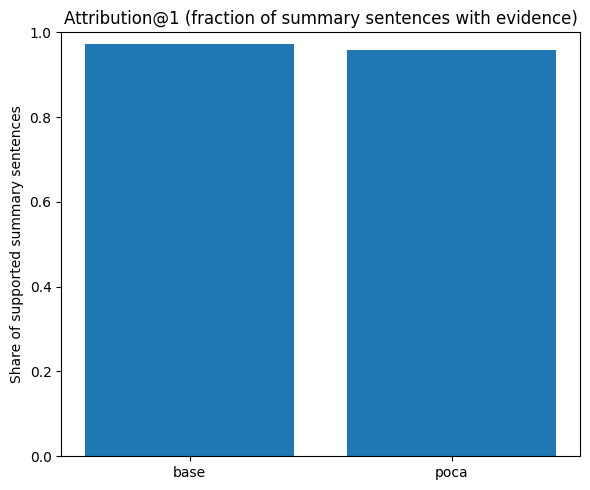

In [ ]:
plt.figure(figsize=(6, 5))

plt.bar(attr_df["system"], attr_df["Attribution_at_1"].astype(float))

plt.ylabel("Share of supported summary sentences")
plt.ylim(0, 1)
plt.title("Attribution@1 (fraction of summary sentences with evidence)")
plt.tight_layout()
plt.show()

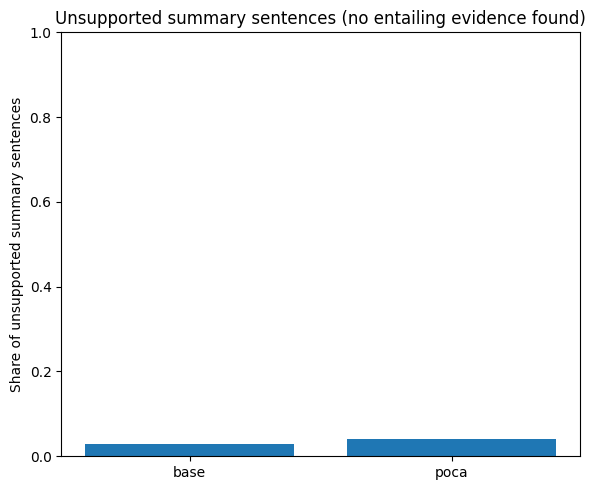

In [ ]:
plt.figure(figsize=(6, 5))

plt.bar(attr_df["system"], attr_df["Unsupported_rate"].astype(float))

plt.ylabel("Share of unsupported summary sentences")
plt.ylim(0, 1)
plt.title("Unsupported summary sentences (no entailing evidence found)")
plt.tight_layout()
plt.show()

## Enhancement 2

Goal: Check whether system summaries capture a fair mix of pros and cons like the gold AmaSum summaries

We build a simple sentence level classifier for pros vs cons using sentiment:
- Pros are usually clearly positive sentences  
- Cons are usually clearly negative sentences

We reuse the same RoBERTa sentiment model and convert each summary sentence into a positive probability

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda" if torch.cuda.is_available() else "cpu"

ckpt_pc = "siebert/sentiment-roberta-large-english"
tok_pc = AutoTokenizer.from_pretrained(ckpt_pc, use_fast=True)
mdl_pc = AutoModelForSequenceClassification.from_pretrained(ckpt_pc).to(device).eval()

def pos_prob_single(text):
    """Return positive sentiment probability for one sentence."""
    text = text.strip()
    if not text:
        return 0.5
    with torch.no_grad():
        enc = tok_pc(text, truncation=True, return_tensors="pt").to(device)
        logits = mdl_pc(**enc).logits
        p = torch.softmax(logits, dim=-1)[0, 1].item()
    return float(p)

Below we:
- Load all gold website pros and cons from the validation split  
- Score each sentence with our sentiment model  
- Try a few candidate positive thresholds  
- Pick the thresholds that best classify gold pros as positive and gold cons as negative

This is how we choose our final positive and negative thresholds in a simple but principled way without touching the test data

In [ ]:
def load_gold_pros_cons(split_name):
    split_dir = amasum / split_name
    pros_sents = []
    cons_sents = []
    for p in split_dir.glob("*.json"):
        data = json.loads(p.read_text(encoding="utf-8"))
        ws0 = data["website_summaries"][0]
        pros = [clean_txt(x) for x in ws0.get("pros", []) if clean_txt(x)]
        cons = [clean_txt(x) for x in ws0.get("cons", []) if clean_txt(x)]
        pros_sents.extend(pros)
        cons_sents.extend(cons)
    return pros_sents, cons_sents

# using the validation set for tuning thresholds only!!
val_pros, val_cons = load_gold_pros_cons("valid")
print("Validation pros sentences:", len(val_pros))
print("Validation cons sentences:", len(val_cons))

val_pros_scores = [pos_prob_single(s) for s in val_pros]
val_cons_scores = [pos_prob_single(s) for s in val_cons]

candidate_ts = [0.55, 0.60, 0.65]
rows = []

for t in candidate_ts:
    pos_t = t
    neg_t = 1.0 - t

    correct = 0
    total = 0

    # pros should be predicted as positive
    pros_pred = [score >= pos_t for score in val_pros_scores]
    correct += sum(pros_pred)
    total += len(val_pros_scores)

    # cons should be predicted as negative
    cons_pred = [score <= neg_t for score in val_cons_scores]
    correct += sum(cons_pred)
    total += len(val_cons_scores)

    acc = correct / total if total > 0 else 0.0
    rows.append({
        "threshold_pos": pos_t,
        "threshold_neg": neg_t,
        "val_accuracy": round(acc, 4)
    })

thresh_df = pd.DataFrame(rows)
print("Validation tuning for pros/cons thresholds:")
display(thresh_df)

best_row = thresh_df.iloc[thresh_df["val_accuracy"].idxmax()]
POS_THRESH = float(best_row["threshold_pos"])
NEG_THRESH = float(best_row["threshold_neg"])

print("Chosen positive threshold:", POS_THRESH)
print("Chosen negative threshold:", NEG_THRESH)

Validation pros sentences: 12332
Validation cons sentences: 5251
Validation tuning for pros/cons thresholds:


,threshold_pos,threshold_neg,val_accuracy
0,0.55,0.45,0.8883
1,0.60,0.40,0.8882
2,0.65,0.35,0.8878


Chosen positive threshold: 0.55
Chosen negative threshold: 0.44999999999999996


We analyze the test summaries for each system using the tuned thresholds

For each system and each product we:
- Count how many sentences in the summary are classified as pros vs cons  
- Compare those counts to the number of gold pros and cons on the dataset  
- Compute the average absolute error in the pro share  
- Compute how often the summary has at least one pro and at least one con

In [ ]:
def analyze_pro_con_coverage(system_name, pred_file, pos_t, neg_t):
    # read system summaries
    hyps_all = [
        ln.strip()
        for ln in open(pred_file, encoding="utf-8").read().splitlines()
    ]
    n = min(len(all_test_ids), len(hyps_all))

    pro_gold_counts = []
    con_gold_counts = []
    pro_sys_counts = []
    con_sys_counts = []
    ratio_errors = []
    has_both_flags = []

    for i in range(n):
        _id = all_test_ids[i]
        jpath = amasum / "test" / f"{_id}.json"
        data = json.loads(jpath.read_text(encoding="utf-8"))
        ws0 = data["website_summaries"][0]

        gold_pros = [clean_txt(x) for x in ws0.get("pros", []) if clean_txt(x)]
        gold_cons = [clean_txt(x) for x in ws0.get("cons", []) if clean_txt(x)]

        n_pro_gold = len(gold_pros)
        n_con_gold = len(gold_cons)
        pro_gold_counts.append(n_pro_gold)
        con_gold_counts.append(n_con_gold)

        summary_text = hyps_all[i]
        sents = [s.strip() for s in sent_tokenize(summary_text) if s.strip()]

        n_pro_sys = 0
        n_con_sys = 0

        for s in sents:
            p = pos_prob_single(s)
            if p >= pos_t:
                n_pro_sys += 1
            elif p <= neg_t:
                n_con_sys += 1
            else:
                pass

        pro_sys_counts.append(n_pro_sys)
        con_sys_counts.append(n_con_sys)

        gold_total_pc = n_pro_gold + n_con_gold
        sys_total_pc = n_pro_sys + n_con_sys

        # so basically...only compute balance error when both sides have at least one pro/cons sentence total
        if gold_total_pc > 0 and sys_total_pc > 0:
            gold_pro_ratio = n_pro_gold / gold_total_pc
            sys_pro_ratio = n_pro_sys / sys_total_pc
            ratio_errors.append(abs(sys_pro_ratio - gold_pro_ratio))

        has_both_flags.append(1 if (n_pro_sys > 0 and n_con_sys > 0) else 0)

    result = {
        "system": system_name,
        "avg_gold_pro_sentences": float(np.mean(pro_gold_counts)),
        "avg_gold_con_sentences": float(np.mean(con_gold_counts)),
        "avg_sys_pro_sentences": float(np.mean(pro_sys_counts)),
        "avg_sys_con_sentences": float(np.mean(con_sys_counts)),
        "avg_pro_ratio_error": float(np.mean(ratio_errors)) if ratio_errors else 0.0,
        "share_with_both_pro_and_con": float(np.mean(has_both_flags)),
    }
    return result

In [ ]:
if SPLIT == "test":
    systems_pc = {
        "base": preds_root / "base_summarizer_flan_t5_large.txt",
        "poca": preds_root / "calibrated_summarizer_PoCa.txt",
    }

    coverage_rows = []
    for name, pred_file in systems_pc.items():
        result = analyze_pro_con_coverage(name, pred_file, POS_THRESH, NEG_THRESH)
        coverage_rows.append(result)

    coverage_df = pd.DataFrame(coverage_rows)
    coverage_csv_path = art / f"aspect_coverage_table_{SPLIT}.csv"
    coverage_df.to_csv(coverage_csv_path, index=False)

    print("Pros/cons coverage table saved to:", coverage_csv_path)
    display(
        coverage_df.rename(
            columns={
                "system": "Summary system",
                "avg_gold_pro_sentences": "Avg gold pros per product",
                "avg_gold_con_sentences": "Avg gold cons per product",
                "avg_sys_pro_sentences": "Avg summary pros per product",
                "avg_sys_con_sentences": "Avg summary cons per product",
                "avg_pro_ratio_error": "Avg pro share error",
                "share_with_both_pro_and_con": "Share of summaries with both pros and cons",
            }
        )
    )
else:
    print("Enhancement 2 runs only for SPLIT ='test'")

Pros/cons coverage table saved to: /content/polarity_calibration_naacl_2024/artifacts/aspect_coverage_table_test.csv


,Summary system,Avg gold pros per product,Avg gold cons per product,Avg summary pros per product,Avg summary cons per product,Avg pro share error,Share of summaries with both pros and cons
0,base,3.945,1.655,4.06,0.785,0.189323,0.715
1,poca,3.945,1.655,3.70,0.890,0.164617,0.805


#### Visuals

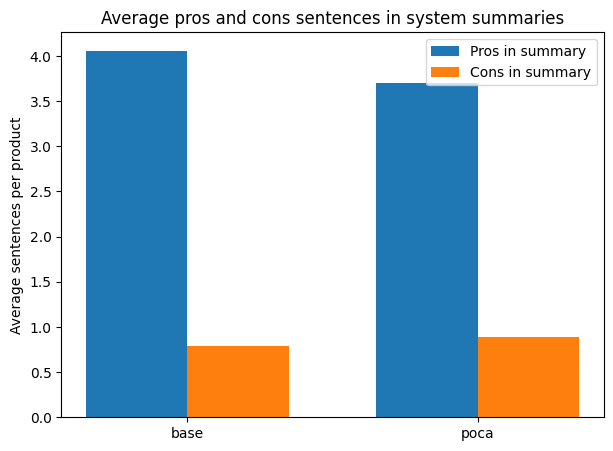

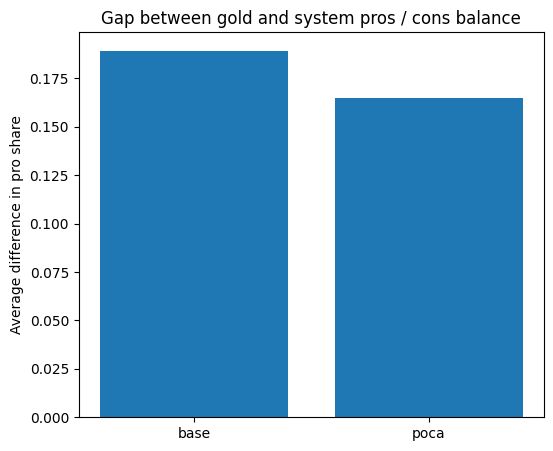

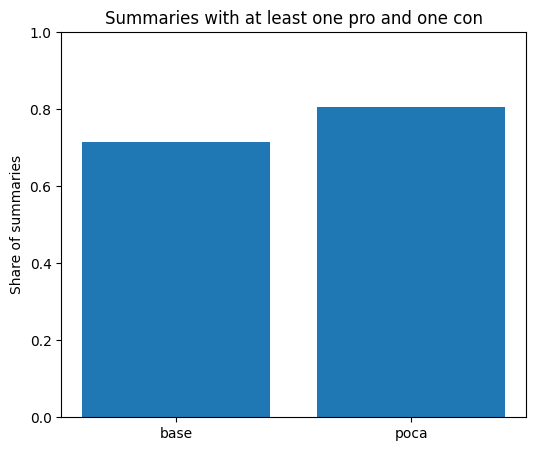

In [ ]:
# average pros and cons sentences in the system summaries
plt.figure(figsize=(7, 5))

x = np.arange(len(coverage_df["system"]))
width = 0.35

pro_vals = coverage_df["avg_sys_pro_sentences"].values
con_vals = coverage_df["avg_sys_con_sentences"].values

plt.bar(x - width/2, pro_vals, width, label="Pros in summary")
plt.bar(x + width/2, con_vals, width, label="Cons in summary")

plt.xticks(x, coverage_df["system"])
plt.ylabel("Average sentences per product")
plt.title("Average pros and cons sentences in system summaries")
plt.legend()
plt.show()

# how far the pro and  con balance is from gold
plt.figure(figsize=(6, 5))
plt.bar(coverage_df["system"], coverage_df["avg_pro_ratio_error"])

plt.ylabel("Average difference in pro share")
plt.title("Gap between gold and system pros / cons balance")
plt.show()

# how often summaries include at least one pro and one con
plt.figure(figsize=(6, 5))
plt.bar(coverage_df["system"], coverage_df["share_with_both_pro_and_con"])

plt.ylabel("Share of summaries")
plt.ylim(0, 1)
plt.title("Summaries with at least one pro and one con")
plt.show()

## Enhancement 3

Goal: Build a new system that...
- Keeps PoCa style sentences that are supported by reviews  
- Fills in missing pros or cons using review sentences when gold pros or cons exist  

We use some stuff from earlier:
- Evidence from Enhancement 1 to know which PoCa sentences are grounded  
- Pros and cons classification from Enhancement 2 to know which sentences are pros and which are cons

High level logic per product:
1. Start from the PoCa summary sentences  
2. Keep only sentences that have at least one entailing evidence sentence  
3. Respect a maximum number of summary sentences
4. If we have gold cons but no con sentences in the kept set, add one extra con sentence from the reviews  
5. If we have gold pros but no pro sentences in the kept set, add one extra pro sentence from the reviews  
6. Join the final sentences into the summary

We save all summaries to a new predictions file

In [ ]:
MAX_SUMM_SENTS = 5

# predictions on test
poca_preds_path = preds_root / "calibrated_summarizer_PoCa.txt"
poca_lines = [
    ln.strip()
    for ln in open(poca_preds_path, encoding="utf-8").read().splitlines()
]

# evidence from Enhancement 1
poca_ev_path = art / f"evidence_poca_{SPLIT}.jsonl"
poca_ev_dict = {}
with open(poca_ev_path, encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        poca_ev_dict[rec["id"]] = rec.get("sentences", [])

print("Loaded evidence entries for poca:", len(poca_ev_dict))

if "review_sents" not in globals():
    review_sents = {}
    for _id in all_test_ids:
        doc = (inp_dir / f"{_id}.txt").read_text(encoding="utf-8")
        sents = [s.strip() for s in sent_tokenize(doc) if s.strip()]
        review_sents[_id] = sents
    print("Rebuilt review sentences for test split:", len(review_sents))


def pick_extra_sentence(_id, want_label):
    cands = review_sents.get(_id, [])
    best_sent = None
    best_score = None
    for text in cands:
        text_clean = clean_txt(text)
        if not text_clean:
            continue
        p = pos_prob_single(text_clean)
        if want_label == "pro":
            if p >= POS_THRESH:
                if best_score is None or p > best_score:
                    best_score = p
                    best_sent = text_clean
        elif want_label == "con":
            if p <= NEG_THRESH:
                if best_score is None or p < best_score:
                    best_score = p
                    best_sent = text_clean
    return best_sent


pocacov_path = preds_root / "calibrated_summarizer_PoCaCov.txt"

with open(pocacov_path, "w", encoding="utf-8") as out_f:
    for i, _id in enumerate(all_test_ids):
        sent_entries = poca_ev_dict.get(_id, [])
        if not sent_entries or i >= len(poca_lines):
            out_f.write(poca_lines[i].strip() + "\n")
            continue

        sent_objs = []
        for entry in sent_entries:
            s = entry.get("summary_sent", "").strip()
            if not s:
                continue
            ev_list = entry.get("evidence", [])
            supported = len(ev_list) > 0
            p = pos_prob_single(s)
            if p >= POS_THRESH:
                label = "pro"
            elif p <= NEG_THRESH:
                label = "con"
            else:
                label = "neutral"
            sent_objs.append({"text": s, "label": label, "supported": supported})

        kept = [s for s in sent_objs if s["supported"]]
        if not kept:
            kept = sent_objs[:]

        if len(kept) > MAX_SUMM_SENTS:
            kept = kept[:MAX_SUMM_SENTS]

        num_pro = sum(1 for s in kept if s["label"] == "pro")
        num_con = sum(1 for s in kept if s["label"] == "con")

        # read pros and cons for this product..
        jpath = amasum / "test" / f"{_id}.json"
        data = json.loads(jpath.read_text(encoding="utf-8"))
        ws0 = data["website_summaries"][0]
        gold_pros = [clean_txt(x) for x in ws0.get("pros", []) if clean_txt(x)]
        gold_cons = [clean_txt(x) for x in ws0.get("cons", []) if clean_txt(x)]

        extra_sents = []
        texts_already = {s["text"] for s in kept}

        # add one con if poca missed cons and gold has cons
        if num_con == 0 and len(gold_cons) > 0:
            extra_con = pick_extra_sentence(_id, "con")
            if extra_con and extra_con not in texts_already:
                extra_sents.append(extra_con)

        # add one pro if poca missed pros and gold has pros
        if num_pro == 0 and len(gold_pros) > 0:
            extra_pro = pick_extra_sentence(_id, "pro")
            if extra_pro and extra_pro not in texts_already:
                extra_sents.append(extra_pro)

        final_sents = [s["text"] for s in kept] + extra_sents
        final_text = " ".join(final_sents).strip()
        out_f.write(final_text + "\n")

print("PoCa+CovEvi summaries written to:", pocacov_path)

Loaded evidence entries for poca: 200
PoCa+CovEvi summaries written to: /content/polarity_calibration_naacl_2024/generated_summary_AmaSum/calibrated_summarizer_PoCaCov.txt


Here we recompute ROUGE for all three systems.

This lets us check how much ROUGE we lose or keep when we enforce coverage and evidence constraints in the new model

In [ ]:
from evaluate import load

if SPLIT == "test":
    systems_e3 = {
        "base": preds_root / "base_summarizer_flan_t5_large.txt",
        "poca": preds_root / "calibrated_summarizer_PoCa.txt",
        "pocacov": preds_root / "calibrated_summarizer_PoCaCov.txt",
    }

    rouge = load("rouge")
    rows = []
    test_ids_ordered = all_test_ids

    for name, pred_file in systems_e3.items():
        hyps_all = [
            ln.strip()
            for ln in open(pred_file, encoding="utf-8").read().splitlines()
        ]
        n = min(len(test_ids_ordered), len(hyps_all))

        refs = [
            (repo / "work_amasum" / f"gold_{SPLIT}" / f"{test_ids_ordered[i]}.txt"
            ).read_text(encoding="utf-8")
            for i in range(n)
        ]
        hyps = [hyps_all[i] for i in range(n)]

        scores = rouge.compute(
            predictions=hyps,
            references=refs,
            use_stemmer=True
        )

        rows.append({
            "system": name,
            "ROUGE1": round(scores["rouge1"] * 100, 2),
            "ROUGE2": round(scores["rouge2"] * 100, 2),
            "ROUGEL": round(scores["rougeL"] * 100, 2),
            "ROUGELsum": round(scores["rougeLsum"] * 100, 2),
        })

    rouge_e3_df = pd.DataFrame(rows)
    rouge_e3_csv = art / f"rouge_summary_table_{SPLIT}_e3.csv"
    rouge_e3_df.to_csv(rouge_e3_csv, index=False)

    print("ROUGE (with PoCa+CovEvi) saved to:", rouge_e3_csv)
    display(
        rouge_e3_df.rename(
            columns={
                "system": "Summary system",
                "ROUGE1": "ROUGE-1 F1",
                "ROUGE2": "ROUGE-2 F1",
                "ROUGEL": "ROUGE-L F1",
                "ROUGELsum": "ROUGE-Lsum F1",
            }
        )
    )
else:
    print("rougee evaluation for enhancement 3 runs only for SPLIT=test!!!")

ROUGE (with PoCa+CovEvi) saved to: /content/polarity_calibration_naacl_2024/artifacts/rouge_summary_table_test_e3.csv


,Summary system,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,ROUGE-Lsum F1
0,base,29.21,5.67,17.18,17.20
1,poca,28.42,5.14,16.95,16.95
2,pocacov,28.03,4.91,16.58,16.57


Using the same polarity pipeline as before...we now:
- Reuse the base and PoCa polarity scores  
- Compute polarity RMSE and MAE for PoCaCov summaries  

We expect PoCaCov to keep or improve polarity alignment

In [ ]:
import pandas as pd

if SPLIT == "test":
    old_pol_df = pd.read_csv(art / f"polarity_summary_table_{SPLIT}.csv")

    pocacov_path = preds_root / "calibrated_summarizer_PoCaCov.txt"
    hyps_all = [
        ln.strip()
        for ln in open(pocacov_path, encoding="utf-8").read().splitlines()
    ]
    n = min(len(all_test_ids), len(hyps_all))

    diffs = []
    for i in range(n):
        _id = all_test_ids[i]
        x = (inp_dir / f"{_id}.txt").read_text(encoding="utf-8")
        y = hyps_all[i]
        pin = pos_prob(x)
        pout = pos_prob(y)
        diffs.append(pout - pin)

    pocacov_row = {
        "system": "pocacov",
        "RMSE": round(rmse(diffs), 4),
        "MAE": round(mae(diffs), 4),
    }

    new_pol_df = pd.concat(
        [old_pol_df, pd.DataFrame([pocacov_row])],
        ignore_index=True
    )

    pol_e3_csv = art / f"polarity_summary_table_{SPLIT}_e3.csv"
    new_pol_df.to_csv(pol_e3_csv, index=False)

    print("Polarity alignment saved to...", pol_e3_csv)
    display(
        new_pol_df.rename(
            columns={
                "system": "Summary system",
                "RMSE": "Polarity RMSE",
                "MAE": "Polarity MAE",
            }
        )
    )
else:
    print("Polarity evaluation for enhancement 3 runs only for SPLIT =test'")

Polarity alignment saved to... /content/polarity_calibration_naacl_2024/artifacts/polarity_summary_table_test_e3.csv


,Summary system,Polarity RMSE,Polarity MAE
0,base,0.2181,0.1775
1,poca,0.1908,0.1557
2,pocacov,0.1459,0.1181


We rerun our pros and cons coverage analysis on the three models

This shows how PoCaCov affects:
- Average number of pro and con sentences  
- Gap between system and gold pro share  
- Share of summaries that contain both pros and cons

In [ ]:
if SPLIT == "test":
    systems_pc_e3 = {
        "base": preds_root / "base_summarizer_flan_t5_large.txt",
        "poca": preds_root / "calibrated_summarizer_PoCa.txt",
        "pocacov": preds_root / "calibrated_summarizer_PoCaCov.txt",
    }

    coverage_rows_e3 = []
    for name, pred_file in systems_pc_e3.items():
        result = analyze_pro_con_coverage(name, pred_file, POS_THRESH, NEG_THRESH)
        coverage_rows_e3.append(result)

    coverage_e3_df = pd.DataFrame(coverage_rows_e3)
    cov_e3_csv = art / f"aspect_coverage_table_{SPLIT}_e3.csv"
    coverage_e3_df.to_csv(cov_e3_csv, index=False)

    print("Pros cons coverage saved to", cov_e3_csv)
    display(
        coverage_e3_df.rename(
            columns={
                "system": "Summary system",
                "avg_gold_pro_sentences": "Avg gold pros per product",
                "avg_gold_con_sentences": "Avg gold cons per product",
                "avg_sys_pro_sentences": "Avg summary pros per product",
                "avg_sys_con_sentences": "Avg summary cons per product",
                "avg_pro_ratio_error": "Avg pro share error",
                "share_with_both_pro_and_con": "Share of summaries with both pros and cons",
            }
        )
    )
else:
    print("coverage evaluation for ehancement 3 runs only for SPLIT =test")

Pros cons coverage saved to /content/polarity_calibration_naacl_2024/artifacts/aspect_coverage_table_test_e3.csv


,Summary system,Avg gold pros per product,Avg gold cons per product,Avg summary pros per product,Avg summary cons per product,Avg pro share error,Share of summaries with both pros and cons
0,base,3.945,1.655,4.06,0.785,0.189323,0.715
1,poca,3.945,1.655,3.70,0.890,0.164617,0.805
2,pocacov,3.945,1.655,3.32,1.030,0.127668,1.000


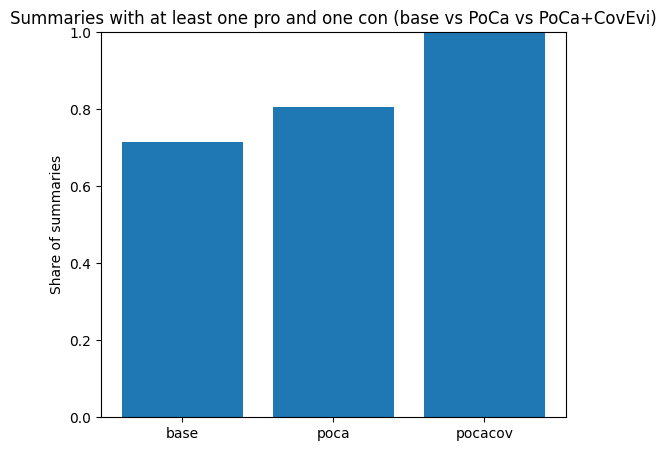

In [ ]:
plt.figure(figsize=(6, 5))
plt.bar(
    coverage_e3_df["system"],
    coverage_e3_df["share_with_both_pro_and_con"]
)

plt.ylabel("Share of summaries")
plt.ylim(0, 1)
plt.title("Summaries with at least one pro and one con (base vs PoCa vs PoCa+CovEvi)")
plt.show()

## Extras

As a small extra analysis we look at high level aspects that show up in gold summaries and system summaries.

We define simple keyword buckets for seven aspects.

This is a lightweight check, not a full aspect model, but it gives a sense of what kinds of topics the systems cover...

In [ ]:
from nltk.tokenize import sent_tokenize

#just a random set of keywords generated using chatgpt...a minor addition which we thought might be cool
aspect_keywords = {
    "price_value": [
        "price", "cost", "cheap", "expensive", "worth it",
        "worth the money", "value", "overpriced", "deal", "bargain"
    ],
    "quality_durability": [
        "quality", "durable", "sturdy", "solid", "well built",
        "broke", "broken", "flimsy", "cheaply made", "sturdiness"
    ],
    "ease_of_use_setup": [
        "easy to use", "easy", "simple", "user friendly", "intuitive",
        "hard to use", "difficult", "complicated", "setup", "set up",
        "install", "installation", "assemble", "assembly", "instructions"
    ],
    "performance": [
        "performance", "works well", "works great", "works fine",
        "does not work", "stopped working", "slow", "fast",
        "lag", "powerful", "effective", "reliable", "unreliable"
    ],
    "appearance_design": [
        "look", "looks", "design", "style", "color", "colors",
        "nice looking", "cute", "beautiful", "ugly", "aesthetic"
    ],
    "size_weight": [
        "size", "sized", "fit", "fits", "too big", "too small",
        "bulky", "compact", "dimensions", "weight", "heavy", "lightweight"
    ],
    "support_shipping": [
        "shipping", "delivery", "delivered", "arrived", "package",
        "packaging", "customer service", "support", "warranty",
        "return", "refund", "replaced", "replacement"
    ],
}

def text_has_aspect(text, keywords):
    t = text.lower()
    for kw in keywords:
        if kw in t:
            return True
    return False

For each product and each aspect we mark:
- Whether the gold summary mentions that aspect  
- Whether the system summary mentions that aspect

For each aspect and each system we compute:
- gold share shows how often that aspect appears in the gold summaries  
- aspect recall shows...among products where the aspect is in the gold summary, how often the system also mentions it

This summarises how well each system covers common aspects like price or performance whenever the gold summary uses them. Again, this is very high-level and just additional extras

In [ ]:
import pandas as pd
import numpy as np
import json

if SPLIT == "test":
    # Prepare gold aspect flags and system aspect flags
    aspect_names = list(aspect_keywords.keys())
    num_products = len(all_test_ids)

    gold_flags = {asp: [] for asp in aspect_names}

    # system -> aspect -> list of bools
    system_flags = {
        "base": {asp: [] for asp in aspect_names},
        "poca": {asp: [] for asp in aspect_names},
        "pocacov": {asp: [] for asp in aspect_names},
    }

    # Load system summaries
    base_summaries = [
        ln.strip()
        for ln in open(preds_root / "base_summarizer_flan_t5_large.txt", encoding="utf-8").read().splitlines()
    ]
    poca_summaries = [
        ln.strip()
        for ln in open(preds_root / "calibrated_summarizer_PoCa.txt", encoding="utf-8").read().splitlines()
    ]
    pocacov_summaries = [
        ln.strip()
        for ln in open(preds_root / "calibrated_summarizer_PoCaCov.txt", encoding="utf-8").read().splitlines()
    ]

    for i, _id in enumerate(all_test_ids):
        # gold text = verdict + pros + cons
        jpath = amasum / "test" / f"{_id}.json"
        data = json.loads(jpath.read_text(encoding="utf-8"))
        ws0 = data["website_summaries"][0]

        gold_verdict = clean_txt(ws0.get("verdict") or "")
        gold_pros = [clean_txt(x) for x in ws0.get("pros", []) if clean_txt(x)]
        gold_cons = [clean_txt(x) for x in ws0.get("cons", []) if clean_txt(x)]

        gold_text = " ".join([gold_verdict] + gold_pros + gold_cons).strip()

        # system texts
        base_text = base_summaries[i] if i < len(base_summaries) else ""
        poca_text = poca_summaries[i] if i < len(poca_summaries) else ""
        pocacov_text = pocacov_summaries[i] if i < len(pocacov_summaries) else ""

        for asp in aspect_names:
            kws = aspect_keywords[asp]

            gold_has = text_has_aspect(gold_text, kws)
            gold_flags[asp].append(gold_has)

            base_has = text_has_aspect(base_text, kws)
            poca_has = text_has_aspect(poca_text, kws)
            pocacov_has = text_has_aspect(pocacov_text, kws)

            system_flags["base"][asp].append(base_has)
            system_flags["poca"][asp].append(poca_has)
            system_flags["pocacov"][asp].append(pocacov_has)

    # Compute aspect recall per system
    rows = []
    for asp in aspect_names:
        gold_list = gold_flags[asp]
        gold_total = sum(gold_list)
        gold_share = gold_total / num_products if num_products > 0 else 0.0

        for system_name in ["base", "poca", "pocacov"]:
            sys_list = system_flags[system_name][asp]

            if gold_total > 0:
                both = sum(1 for g, s in zip(gold_list, sys_list) if g and s)
                recall = both / gold_total
            else:
                recall = 0.0

            rows.append({
                "aspect": asp,
                "system": system_name,
                "gold_share": gold_share,
                "aspect_recall": recall,
            })

    aspect_recall_df = pd.DataFrame(rows)
    aspect_recall_csv = art / f"aspect_recall_{SPLIT}.csv"
    aspect_recall_df.to_csv(aspect_recall_csv, index=False)

    print("saved to", aspect_recall_csv)
    display(aspect_recall_df)
else:
    print("runs only for split=test")

saved to /content/polarity_calibration_naacl_2024/artifacts/aspect_recall_test.csv


,aspect,system,gold_share,aspect_recall
0,price_value,base,0.415,0.397590
1,price_value,poca,0.415,0.349398
2,price_value,pocacov,0.415,0.337349
3,quality_durability,base,0.500,0.480000
4,quality_durability,poca,0.500,0.510000
5,quality_durability,pocacov,0.500,0.480000
6,ease_of_use_setup,base,0.355,0.845070
7,ease_of_use_setup,poca,0.355,0.845070
8,ease_of_use_setup,pocacov,0.355,0.830986
9,performance,base,0.260,0.269231


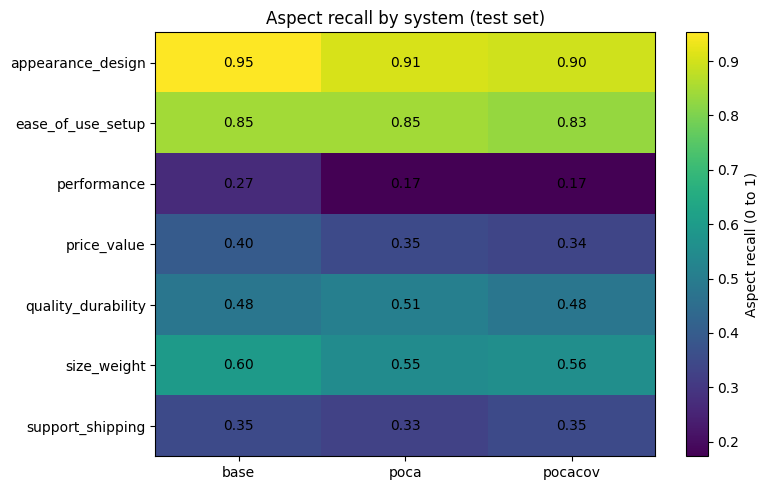

In [ ]:
import matplotlib.pyplot as plt

recall_pivot = aspect_recall_df.pivot(index="aspect", columns="system", values="aspect_recall")

plt.figure(figsize=(8, 5))

mat = recall_pivot.values
plt.imshow(mat, aspect="auto")

plt.xticks(range(len(recall_pivot.columns)), recall_pivot.columns)
plt.yticks(range(len(recall_pivot.index)), recall_pivot.index, rotation=0)

plt.colorbar(label="Aspect recall (0 to 1)")
plt.title("Aspect recall by system (test set)")

for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        val = mat[i, j]
        plt.text(
            j, i,
            f"{val:.2f}",
            ha="center", va="center"
        )

plt.tight_layout()
plt.show()

In [ ]:
rouge_all = rouge_e3_df.copy()
pol_all = new_pol_df.copy()
cov_all = coverage_e3_df.copy()
summary_df = (
    rouge_all.merge(pol_all, on="system")
             .merge(cov_all, on="system")
)

summary_df = summary_df[[
    "system",
    "ROUGE1", "ROUGE2", "ROUGEL", "ROUGELsum",
    "RMSE", "MAE",
    "avg_sys_pro_sentences",
    "avg_sys_con_sentences",
    "avg_pro_ratio_error",
    "share_with_both_pro_and_con",
]]

summary_df = summary_df.rename(columns={
    "system": "Summary system",
    "ROUGE1": "ROUGE-1 F1",
    "ROUGE2": "ROUGE-2 F1",
    "ROUGEL": "ROUGE-L F1",
    "ROUGELsum": "ROUGE-Lsum F1",
    "RMSE": "Polarity RMSE",
    "MAE": "Polarity MAE",
    "avg_sys_pro_sentences": "Avg summary pros per product",
    "avg_sys_con_sentences": "Avg summary cons per product",
    "avg_pro_ratio_error": "Avg pro share error",
    "share_with_both_pro_and_con": "Share of summaries with both pros and cons",
})

display(summary_df)

,Summary system,ROUGE-1 F1,ROUGE-2 F1,ROUGE-L F1,ROUGE-Lsum F1,Polarity RMSE,Polarity MAE,Avg summary pros per product,Avg summary cons per product,Avg pro share error,Share of summaries with both pros and cons
0,base,29.21,5.67,17.18,17.20,0.2181,0.1775,4.06,0.785,0.189323,0.715
1,poca,28.42,5.14,16.95,16.95,0.1908,0.1557,3.70,0.890,0.164617,0.805
2,pocacov,28.03,4.91,16.58,16.57,0.1459,0.1181,3.32,1.030,0.127668,1.000
